# Shchepetkin and McWilliams (2002)


Notebook to reproduce Shchepetkin and McWilliams (2002) bathymetry for the SEAMOUNT test case. The code is a literal translation (a part for the indexes convention) of the original Fortran90 code

In [166]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Input parameters

### Physical domain

In [167]:
rn_xdim    = 320.     # x-dimension of the domain [km]
rn_ydim    = 320.     # y-dimension of the domain [km]
rn_bot_max = 5000.    # max ocean depth (>0) [m]
rn_smnt_H  = 4500.    # seamount height (>0) [m]
rn_smnt_L  = 40.      # seamount width [km]
rn_fplane  = 0.0001   # Coriolis parameter for f-plane approximation

### Numerical Discretization

In [168]:
rn_dx      = 6700.    # horizontal resolution [m]
rn_dz      = 454.55   # vertical resolution far from the seamount
                      # and assuming no stretching [m]

### Vertical coordinate

In [169]:
ln_zco     = False   # z-coordinate
ln_zps     = False   # z-partial-step coordinate
ln_sco     = True    # s-coordinate
# Stretched s-levels (ln_sco = .true.)
ln_s_sh94  = True    # TRUE:  s-levels using Song & Haidvogel 1994 (SH94)
                     #        stretching function
                     # FALSE: uniform sigma-levels
rn_theta   = 3.0     # SH94 surface control parameter (0<=theta<=20)
rn_bb      = 0.0     # SH94 bottom control parameter (0<=bb<=1)
rn_hc      = 500     # SH94 critical depth for transition to stretched coordinates [m]
# Paramaters for vqs-coordinate (ln_sco = .true.)
ln_vqs     = False   # activating vanishing quasi-sigma levels (TRUE)
rn_rmax    = 0.3     # maximum cut-off slope parameter value allowed
                     # if using vqs-levels (0<r_max<1)

## 2. Computing horizontal T-grid

In [170]:
ni = int( 1000. * rn_xdim / rn_dx ) + 1
nj = int( 1000. * rn_ydim / rn_dx ) + 1
nk = int( rn_bot_max  / rn_dz ) + 1

plamt = np.zeros(shape=(nj,ni))
pphit = np.zeros(shape=(nj,ni))
zfact = rn_dx * 1.e-3         # conversion in km
for j in range(nj):
    for i in range(ni):
        plamt[j,i] = zfact * ( 0.5 + i )
        pphit[j,i] = zfact * ( 0.5 + j )

## 3. Computing seamount bathymetry

In [171]:
zlam_mid = 0.5 * 1000. * rn_xdim
zphi_mid = 0.5 * 1000. * rn_ydim
bathy = np.zeros(shape=(nj,ni))
for j in range(nj):
    for i in range(ni):
        bathy[j,i] = rn_bot_max - rn_smnt_H * \
                     np.exp(-((1000. * plamt[j,i] - zlam_mid)**2 + \
                             (1000. * pphit[j,i] - zphi_mid)**2  ) / \
                             ( 1000. * rn_smnt_L)**2 )

### Plot 

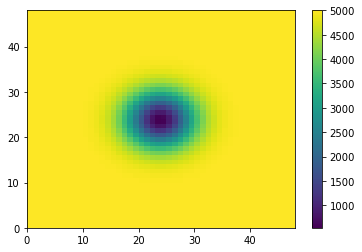

In [172]:
plt.figure()
plt.pcolormesh(bathy)
plt.colorbar()

## 4. Computing vertical levels

In [173]:
def sigma_coord():
    sigT = np.zeros(shape=(nk,))
    sigW = np.zeros(shape=(nk,))
    for k in range(nk):
        sigT[k] = ((k) + 0.5 ) / (nk-1)
        sigW[k] = (k) / (nk-1)
    return sigT, sigW

In [174]:
def sh94_coord(sigT, sigW):
    if rn_theta > 0. :
        for k in range(nk):
            sT = sigT[k]
            sW = sigW[k]
            sigT[k] = (1. - rn_bb) * np.sinh(rn_theta * sT) / np.sinh(rn_theta) + rn_bb * \
                      ( ( np.tanh(rn_theta * (sT + 0.5)) - np.tanh(0.5 * rn_theta) ) / \
                      (2. * np.tanh(0.5 * rn_theta) ) )
            sigW[k] = (1. - rn_bb) * np.sinh(rn_theta * sW) / np.sinh(rn_theta) + rn_bb * \
                      ( ( np.tanh(rn_theta * (sW + 0.5)) - np.tanh(0.5 * rn_theta) ) / \
                      (2. * np.tanh(0.5 * rn_theta) ) )
    return sigT, sigW

In [175]:
sigmaT, sigmaW = sigma_coord()

In [176]:
sT, sW = sh94_coord(sigmaT, sigmaW)

In [177]:
pdept = np.zeros(shape=(nk,nj,ni))
pdepw = np.zeros(shape=(nk,nj,ni))
for j in range(nj):
    for i in range(ni):
        for k in range(nk):
            pdept[k,j,i] = rn_hc * sT[k] + sT[k] * (bathy[j,i] - rn_hc)
            pdepw[k,j,i] = rn_hc * sW[k] + sW[k] * (bathy[j,i] - rn_hc)

### Plot 

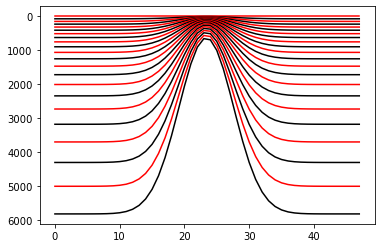

In [178]:
plt.figure()
for k in range(nk):
    plt.plot(pdepw[k,int(nj/2),:],'r')
    plt.plot(pdept[k,int(nj/2),:],'k')
plt.gca().invert_yaxis()